In [23]:
from datacleanv2 import *
from SetRNN import *
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence, pad_packed_sequence
from collections import Counter # 用于统计计数的工具
import time # 用于计时
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils # 用于处理变长序列，如填充和打包
from torch.utils.data import Dataset, DataLoader # PyTorch 数据加载工具
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm # 进度条库，使用 tqdm.tqdm
import random
import pyreadstat
import copy # 用于复制模型参数或列表
import matplotlib.pyplot as plt # 用于绘图
import seaborn as sns # 用于更美观的统计图，特别是热力图
import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EARLY_ITER_BATCH_THRESHOLD = 3 # 在前 3 轮迭代中使用部分批次 (适应总迭代 10)
EARLY_ITER_BATCH_PERCENT = 0.3

# 超参数和常量定义
NUM_MAIN_MODELS = 3 # 主要的聚类模型数量
NUM_COMBINED_SETTINGS = 23 # combined_setting 的总类别数 (0-124)
EMBEDDING_DIM = 8 # combined_setting 的嵌入向量维度，可调整
HIDDEN_SIZE = 64   # RNN 隐藏层大小，可调整
NUM_RNN_LAYERS = 2 # RNN 层数
# 注意: TIME_LOSS_SCALER 可能需要根据实际 delta_t 的规模重新调整
TIME_LOSS_SCALER = 1 # time delta_t MSE 损失的缩放因子，需要根据实际损失值大小调整
TOTAL_EM_ITERATIONS = 10 # EM 迭代总次数 (根据要求修改为 10)
CONVERGENCE_THRESHOLD = 0.05 # 收敛阈值，分配改变的序列比例低于此值时停止 (5%)

# 干扰项处理参数
NUM_RAND_SEQUENCES = 250 # 干扰项的已知数量
INTERFERENCE_CLUSTER_LABEL = 3 # 将干扰项分配到的簇的索引 (0, 1, 2 是主簇，3 是干扰簇)
INTERFERENCE_DETECTION_START_ITER = 2 # 从第 5 轮迭代 (索引 4) 的 E 步开始检测干扰项
# 检测干扰项的高损失阈值：需要根据训练中观察到的损失值范围来调整
# 如果一个序列在所有模型上的平均损失超过这个阈值，则可能被认为是干扰项。
# ！！！重要参数，需要根据实际运行观察的损失值调整！！！
# 在模拟数据上运行一次，观察损失值的分布，尤其是 rand_label 序列的损失。
HIGH_AVG_LOSS_THRESHOLD = 0.5 ## <--- !!! 初始值，请务必根据实际情况调整 !!!

# M 步训练参数 (每个 EM 迭代中的训练 epochs)
# epochs 计划表：根据迭代次数使用不同数量的 epochs
EPOCH_SCHEDULE = [1] * 5 + [2]* 5 # 示例：前 3 轮迭代训练 2 epoch，接下来 7 轮训练 5 epoch (适应总迭代 10)
BATCH_SIZE = 32 # M 步训练时的批次大小
# 在早期迭代中是否只使用部分批次来加速训练
EARLY_ITER_BATCH_THRESHOLD = 3 # 在前 3 轮迭代中使用部分批次 (适应总迭代 10)
EARLY_ITER_BATCH_PERCENT = 0.3 # 在启用部分批次训练时使用的批次比例 (30%)

In [24]:
df_response = pd.read_csv(r"E:\复旦大学\研一上\科研\评分剪枝算法\数据\traffic\traffic_q2_response.csv")
df_seq = pd.read_csv(r"E:\复旦大学\研一上\科研\评分剪枝算法\数据\traffic\traffic_q2_seq.csv")


In [25]:
# 1. 将action的列名改为combined_setting
df_seq = df_seq.rename(columns={'action': 'combined_setting'})
df_seq["combined_setting"] = df_seq["combined_setting"] - 1  # 假设原始数据是从1开始的，这里将其转换为从0开始
# 2. 将数据框切割，连续的ID相同的行被切割进同一个数据框
# 创建分组标识：当ID发生变化时开始新分组

# 按分组切割数据框并组成列表
grouped_dfs = [group for _, group in df_seq.groupby('ID')]

print(f"切割后得到 {len(grouped_dfs)} 个数据框")

# 3. 去除每个数据框元素的第一行和最后一行
# 4. 去除所有长度小于3的数据框（去除后长度至少为1）
filtered_dfs = []

for i, df_group in enumerate(grouped_dfs):
    # 如果数据框长度大于等于3，才进行处理
    if len(df_group) >= 5:
        # 去除第一行和最后一行
        trimmed_df = df_group.iloc[1:-1].copy()
      
        matching_row = df_response[df_response['ID'] == trimmed_df['ID'].iloc[0]]
        response_value = matching_row['Response'].iloc[0] 
        trimmed_df = trimmed_df.drop(columns=['ID'])
        filtered_dfs.append([trimmed_df, response_value])  # 假设 df_response 的索引与 grouped_dfs 对应


切割后得到 31656 个数据框


In [26]:
loaded_list = filtered_dfs

# 读取分类结果
final_assignment_list= np.load("final_assignments_traffic.npy")

# 读取模型参数
models = [SettingPredictorRNN(embedding_dim=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_rnn_layers=NUM_RNN_LAYERS, num_categories=NUM_COMBINED_SETTINGS).to(device) for _ in range(NUM_MAIN_MODELS)]
models[0] = torch.load("model1_traffic.pth",weights_only=False)
models[1] = torch.load("model2_traffic.pth",weights_only=False)   
models[2] = torch.load("model3_traffic.pth",weights_only=False)
Model = torch.load("TotalModel_traffic.pth",weights_only=False)

## 使用整体模型删高阈值

### 使用整体模型对每一步进行评估

In [27]:
#计算每个序列的损失
setting_loss_list=[None]*len(loaded_list)
time_loss_list=[None]*len(loaded_list)
for i in range(len(loaded_list)):
    seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
    seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
    time_criterion = nn.MSELoss(reduction= "sum")
    setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
    if final_assignment_list[i] >= len(models):
        setting_loss_list[i] = [0]
        time_loss_list[i] = [0]
        continue
    model = Model

    #deltaT_inputs是时间差的输入，setting_inputs是设置的输入
    #使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
    deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
    setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)

    deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
    setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)

    input_len = seq_time.shape[0] - 2#输出输出的长度
    length = torch.tensor([input_len])

    #模型预测
    predict_deltaT, predict_setting,_ = model(deltaT_inputs, setting_inputs, length)
    
    #计算损失
    seq_time_loss_tensor=[time_criterion(predict_deltaT.squeeze(0)[i], deltaT_targets.squeeze(0)[i]) for i in range(predict_deltaT.squeeze(0).shape[0])]
    seq_setting_loss_tensor=[setting_criterion(predict_setting.squeeze(0)[i].unsqueeze(0), setting_targets.squeeze(0)[i].unsqueeze(0)) for i in range(predict_setting.squeeze(0).shape[0])]
    
    seq_setting_loss_list=[_.item() for _ in seq_time_loss_tensor]
    seq_time_loss_list=[_.item() for _ in seq_setting_loss_tensor]
    setting_loss_list[i]=seq_setting_loss_list
    time_loss_list[i]=seq_time_loss_list

#total_loss_list代表每个列表每一步的总损失
total_loss_list = [[setting_loss_list[i][j]+ time_loss_list[i][j] for j in range(len(setting_loss_list[i]))]for i in range(len(setting_loss_list)) ]
    
    

In [28]:
#将损失列表展平
#setting_loss_distribution 和 time_loss_distribution分别为设置和时间的损失值展平
setting_loss_distribution=[item for list_item in setting_loss_list for item in list_item]
time_loss_distribution=[item for list_item in time_loss_list for item in list_item]
#Total_step_length为所有步骤的总数
total_step_length=len(setting_loss_distribution)
#将两种损失相加，得到每个步骤的总损失total_loss_distribution
total_loss_distribution=[setting_loss_distribution[i] + time_loss_distribution[i] for i in range(len(setting_loss_distribution))]

In [29]:
threshold=95
setting_threshold = np.percentile(setting_loss_distribution, threshold)
time_threshold = np.percentile(time_loss_distribution, threshold)
print("Setting Loss",threshold,"th Percentile:", setting_threshold,"\nTime Loss ",threshold,"th Percentile:", time_threshold)
total_threshold = np.percentile(total_loss_distribution, threshold)
print("total Loss",threshold,"th Percentile:", total_threshold)

Setting Loss 95 th Percentile: 18.273713302612272 
Time Loss  95 th Percentile: 4.224609899520873
total Loss 95 th Percentile: 19.97885090485212


In [30]:
outliers = [(i, j) for i, chain in enumerate(total_loss_list) for j, loss in enumerate(chain) if loss > total_threshold]
print("共从",total_step_length,"个步骤中检测到",len(outliers),"个异常值")

共从 791979 个步骤中检测到 39599 个异常值


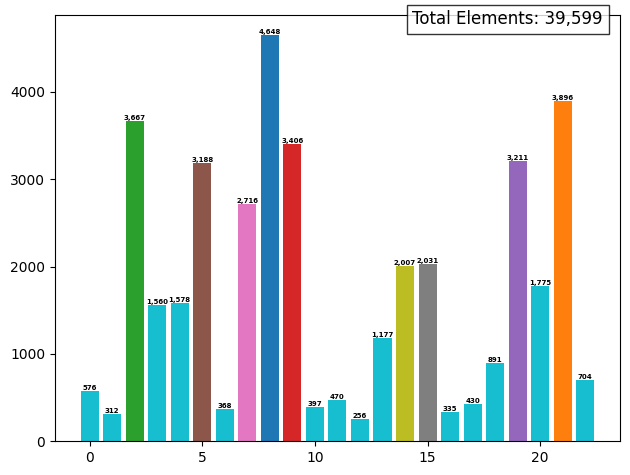

In [31]:
#先绘制被标记setting分布
Pruned_Setting=[loaded_list[i][0]["combined_setting"].values[j+1] for i, j in outliers] # 仅保留异常值对应的序列
result = Counter(Pruned_Setting).most_common(30)
elements, counts = zip(*result)

# 绘制条形图
colors = plt.cm.tab10(np.arange(len(elements)))
bars = plt.bar(elements, counts, color=colors)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',  # 格式化数字添加千位分隔符
             ha='center', va='bottom',
             fontsize=5, fontweight='bold')
    
    # 添加总数信息
total = len(Pruned_Setting)
plt.figtext(0.95, 0.95, f'Total Elements: {total:,}', 
            ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

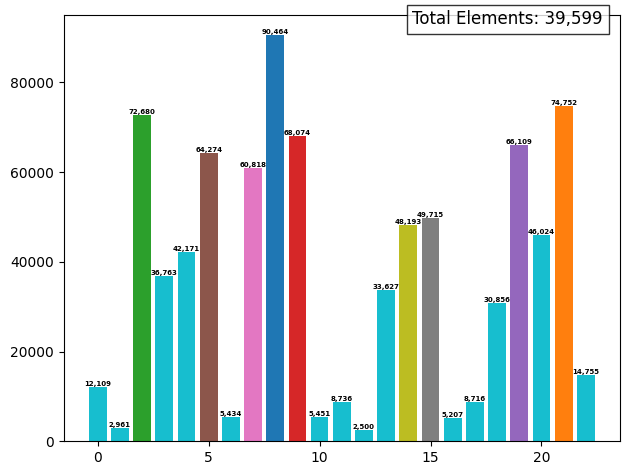

In [32]:
#绘制全体setting分布
All_Setting=[loaded_list[i][0]["combined_setting"].values[j] for i in range(len(loaded_list)) for j in range(len(loaded_list[i][0]["combined_setting"].values))]
result = Counter(All_Setting).most_common(30)
all_elements, counts = zip(*result)

# 绘制条形图
colors = plt.cm.tab10(np.arange(len(elements)))
bars = plt.bar(elements, counts, color=colors)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',  # 格式化数字添加千位分隔符
             ha='center', va='bottom',
             fontsize=5, fontweight='bold')
    
# 添加总数信息
total = len(Pruned_Setting)
plt.figtext(0.95, 0.95, f'Total Elements: {total:,}', 
            ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

### 依据整体模型的标记重新分类

In [33]:
pruned_setting_loss_list=[None]*len(loaded_list)
pruned_time_loss_list=[None]*len(loaded_list)
changed_seq=[]
for i in range(len(loaded_list)):#第i个序列
    seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
    seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
    time_criterion = nn.MSELoss(reduction= "sum")
    setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
    if final_assignment_list[i] >= len(models):
        setting_loss_list[i] = [0]
        time_loss_list[i] = [0]
        continue

    #deltaT_inputs是时间差的输入，setting_inputs是设置的输入
    #使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
    deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
    setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)

    deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
    setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)

    input_len = seq_time.shape[0] - 2#输出输出的长度
    length = torch.tensor([input_len])
    
    #复制原始输入和目标张量，以便在删除异常点后进行修剪,将张量转换为列表（保留二维结构）,存入“pruned_...类型_输入/输出_list”中
    pruned_deltaT_inputs_list, pruned_setting_inputs_list, pruned_deltaT_targets_list, pruned_setting_targets_list= deltaT_inputs.clone().tolist(), setting_inputs.clone().tolist(), deltaT_targets.clone().tolist(), setting_targets.clone().tolist()
    indices_to_remove = [y for _, y in outliers if _ ==i]# 从outlier中提取所有序列标号为i的异常点（即第一个元素为i的数组),忽略x，只取y
    indices_to_remove = sorted(list(set(indices_to_remove)),reverse=True)  # 去重,降序排序(先删后面的，避免改变索引位置),indices_to_remove是储存第i个序列中需要删除的索引列表,注意sorted和.sort的区别
    #***测试用待删print(i,indices_to_remove)

    # 如果没有可删除的，则跳过
    if not indices_to_remove:
        continue
    # 如果所有步骤都是异常点，则跳过
    # ***是否要记录所有步骤都异常的序列的总数**？
    if len(pruned_deltaT_inputs_list[0]) == len(indices_to_remove):
        print("序列",i,"的所有步骤均为异常点，跳过")
        continue
    for index in indices_to_remove:
        # 检查索引index是否在有效范围内
        if 0 <= index < len(pruned_deltaT_inputs_list[0]):# 删除被标记的步骤 <bug:只删去了t_input的异常点,忘记了其他的>
            del pruned_deltaT_inputs_list[0][index]
            del pruned_setting_inputs_list[0][index]
            del pruned_deltaT_targets_list[0][index]
            del pruned_setting_targets_list[0][index]
        else:
            # 可选：处理索引越界情况（例如打印警告或忽略）
            print(f"警告: 索引 {index} 超出范围，忽略删除")
            # 或者直接忽略

    pruned_deltaT_inputs, pruned_setting_inputs, pruned_deltaT_targets, pruned_setting_targets = torch.tensor(pruned_deltaT_inputs_list).to(device),torch.tensor(pruned_setting_inputs_list).to(device), torch.tensor(pruned_deltaT_targets_list).to(device), torch.tensor(pruned_setting_targets_list).to(device)
    # 现在，pruned_()_() 就是删除异常点后的数据链,<bug:忘记使用to(device)>
    pruned_length = torch.tensor([pruned_deltaT_inputs.shape[1]])#pruned_length为删除后的长度，从数据中取，并转化为张量

    #***检验用待删print(pruned_deltaT_inputs_list.shape,pruned_length, pruned_setting_inputs.shape[1])

    #使用所有模型分别计算损失
    model_loss = [0] * len(models) # 初始化每个模型的损失列表
    for j in range(len(models)):
        model = models[j]

        #模型预测
        pruned_predict_deltaT, pruned_predict_setting,_ = model(pruned_deltaT_inputs, pruned_setting_inputs, pruned_length)

        #计算损失,seq代表按每一步计损失并编入列表
        pruned_seq_time_loss_tensor=[time_criterion(pruned_predict_deltaT.squeeze(0)[i], pruned_deltaT_targets.squeeze(0)[i]) for i in range(pruned_predict_deltaT.squeeze(0).shape[0])]
        pruned_seq_setting_loss_tensor=[setting_criterion(pruned_predict_setting.squeeze(0)[i].unsqueeze(0), pruned_setting_targets.squeeze(0)[i].unsqueeze(0)) for i in range(pruned_predict_setting.squeeze(0).shape[0])]
        pruned_seq_setting_loss_list=[_.item() for _ in pruned_seq_time_loss_tensor]
        pruned_seq_time_loss_list=[_.item() for _ in pruned_seq_setting_loss_tensor]

        model_loss[j] = sum(pruned_seq_setting_loss_list)+ sum(pruned_seq_time_loss_list) # 计算剪后序列i在模型j上的总损失
        #***测试用待删print(model_loss[j])

    min_modelloss = min(model_loss)
    min_modelindex = model_loss.index(min_modelloss)#找出剪后的最佳模型
    if min_modelindex != final_assignment_list[i] and final_assignment_list[i] < len(models):#若与原分配不同，则打印并记录
        print("序列",i,"的最佳模型由",final_assignment_list[i],"变为",min_modelindex)
        changed_seq.append(i)
    #else:
    #    ***测试用待删print("模型损失:",model_loss,"序号不变",final_assignment_list[i])#<bug:在print()立马加入print(model_loss)会输出None>

print("总序列数",len(loaded_list))
print("标记数（被重新分类的）",len(set([i[0] for i in outliers])))
print("被改变序列数",len(changed_seq))
print()

序列 4 的最佳模型由 0 变为 2
序列 5 的最佳模型由 1 变为 2
序列 9 的最佳模型由 1 变为 2
序列 15 的最佳模型由 1 变为 2
序列 19 的最佳模型由 0 变为 2
序列 23 的最佳模型由 1 变为 2
序列 26 的最佳模型由 0 变为 2
序列 27 的最佳模型由 0 变为 2
序列 44 的最佳模型由 1 变为 2
序列 45 的最佳模型由 1 变为 2
序列 49 的最佳模型由 1 变为 2
序列 50 的最佳模型由 0 变为 2
序列 53 的最佳模型由 0 变为 2
序列 66 的最佳模型由 1 变为 2
序列 67 的最佳模型由 1 变为 2
序列 69 的最佳模型由 1 变为 2
序列 79 的最佳模型由 1 变为 2
序列 89 的最佳模型由 1 变为 2
序列 97 的最佳模型由 0 变为 2
序列 104 的最佳模型由 1 变为 2
序列 105 的最佳模型由 1 变为 2
序列 113 的最佳模型由 1 变为 2
序列 119 的最佳模型由 0 变为 1
序列 132 的最佳模型由 0 变为 2
序列 158 的最佳模型由 1 变为 2
序列 166 的最佳模型由 0 变为 1
序列 167 的最佳模型由 0 变为 2
序列 170 的最佳模型由 1 变为 2
序列 178 的最佳模型由 1 变为 2
序列 179 的最佳模型由 1 变为 2
序列 184 的最佳模型由 1 变为 2
序列 193 的最佳模型由 0 变为 2
序列 197 的最佳模型由 1 变为 2
序列 205 的最佳模型由 1 变为 2
序列 207 的最佳模型由 1 变为 2
序列 209 的最佳模型由 1 变为 2
序列 211 的最佳模型由 1 变为 2
序列 213 的最佳模型由 0 变为 2
序列 214 的最佳模型由 0 变为 2
序列 215 的最佳模型由 0 变为 2
序列 216 的最佳模型由 0 变为 2
序列 221 的最佳模型由 1 变为 2
序列 226 的最佳模型由 0 变为 2
序列 231 的最佳模型由 0 变为 2
序列 234 的最佳模型由 0 变为 1
序列 240 的最佳模型由 1 变为 2
序列 241 的最佳模型由 1 变为 2
序列 264 的最佳模型由 0 变为 2
序列 267 的最佳模型由 

In [34]:
print("总序列数",len(loaded_list))
print("标记数（被重新分类的）",len(set([i[0] for i in outliers])))
print("被改变序列数",len(changed_seq))
print()
# 统计数据


总序列数 26773
标记数（被重新分类的） 16689
被改变序列数 4680



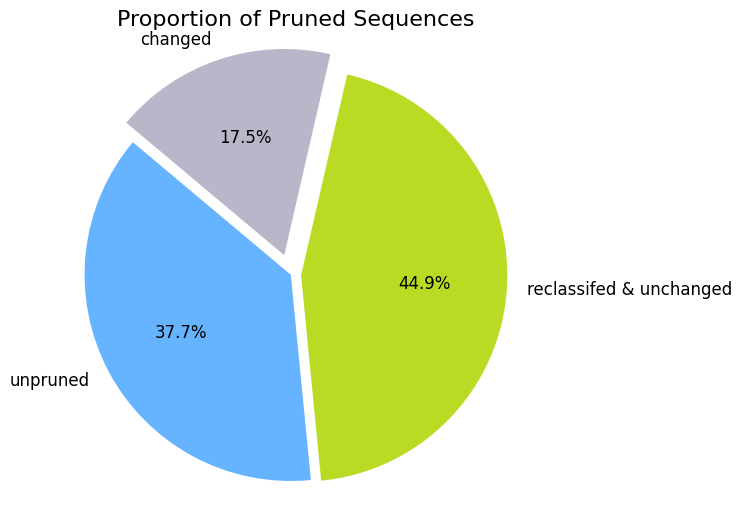

a


In [35]:
total_sequences = len(loaded_list)
reclassified_sequences = len(set([i[0] for i in outliers]))
changed_sequences = len(changed_seq)
unchanged_sequences = total_sequences - reclassified_sequences
reclassified_only = reclassified_sequences - changed_sequences

labels = ['unpruned', 'reclassifed & unchanged', 'changed']
sizes = [unchanged_sequences, reclassified_only, changed_sequences]
colors = ['#66b3ff', "#B9DB24", "#bbb5c9"]
explode = (0, 0.05, 0.1)  # 突出显示

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
plt.title('Proportion of Pruned Sequences', fontsize=16)
plt.axis('equal')
plt.show()
print("a")

## 使用整体模型删低阈值

### 使用整体模型对每一步进行评估

In [36]:
#计算每个序列的损失
setting_loss_list=[None]*len(loaded_list)
time_loss_list=[None]*len(loaded_list)
for i in range(len(loaded_list)):
    seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
    seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
    time_criterion = nn.MSELoss(reduction= "sum")
    setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
    if final_assignment_list[i] >= len(models):
        setting_loss_list[i] = [0]
        time_loss_list[i] = [0]
        continue
    model = Model

    #deltaT_inputs是时间差的输入，setting_inputs是设置的输入
    #使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
    deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
    setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)

    deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
    setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)

    input_len = seq_time.shape[0] - 2#输出输出的长度
    length = torch.tensor([input_len])

    #模型预测
    predict_deltaT, predict_setting,_ = model(deltaT_inputs, setting_inputs, length)
    
    #计算损失
    seq_time_loss_tensor=[time_criterion(predict_deltaT.squeeze(0)[i], deltaT_targets.squeeze(0)[i]) for i in range(predict_deltaT.squeeze(0).shape[0])]
    seq_setting_loss_tensor=[setting_criterion(predict_setting.squeeze(0)[i].unsqueeze(0), setting_targets.squeeze(0)[i].unsqueeze(0)) for i in range(predict_setting.squeeze(0).shape[0])]
    
    seq_setting_loss_list=[_.item() for _ in seq_time_loss_tensor]
    seq_time_loss_list=[_.item() for _ in seq_setting_loss_tensor]
    setting_loss_list[i]=seq_setting_loss_list
    time_loss_list[i]=seq_time_loss_list

#total_loss_list代表每个列表每一步的总损失
total_loss_list = [[setting_loss_list[i][j]+ time_loss_list[i][j] for j in range(len(setting_loss_list[i]))]for i in range(len(setting_loss_list)) ]
    
    

In [37]:
#将损失列表展平
#setting_loss_distribution 和 time_loss_distribution分别为设置和时间的损失值展平
setting_loss_distribution=[item for list_item in setting_loss_list for item in list_item]
time_loss_distribution=[item for list_item in time_loss_list for item in list_item]
#Total_step_length为所有步骤的总数
total_step_length=len(setting_loss_distribution)
#将两种损失相加，得到每个步骤的总损失total_loss_distribution
total_loss_distribution=[setting_loss_distribution[i] + time_loss_distribution[i] for i in range(len(setting_loss_distribution))]

In [38]:
threshold=50
setting_threshold = np.percentile(setting_loss_distribution, threshold)
time_threshold = np.percentile(time_loss_distribution, threshold)
print("Setting Loss",threshold,"th Percentile:", setting_threshold,"\nTime Loss ",threshold,"th Percentile:", time_threshold)
total_threshold = np.percentile(total_loss_distribution, threshold)
print("total Loss",threshold,"th Percentile:", total_threshold)

Setting Loss 50 th Percentile: 0.7927581071853638 
Time Loss  50 th Percentile: 1.3466964960098267
total Loss 50 th Percentile: 2.6928468979895115


In [39]:
outliers = [(i, j) for i, chain in enumerate(total_loss_list) for j, loss in enumerate(chain) if loss < total_threshold]
print("共从",total_step_length,"个步骤中检测到",len(outliers),"个异常值")

共从 791979 个步骤中检测到 395989 个异常值


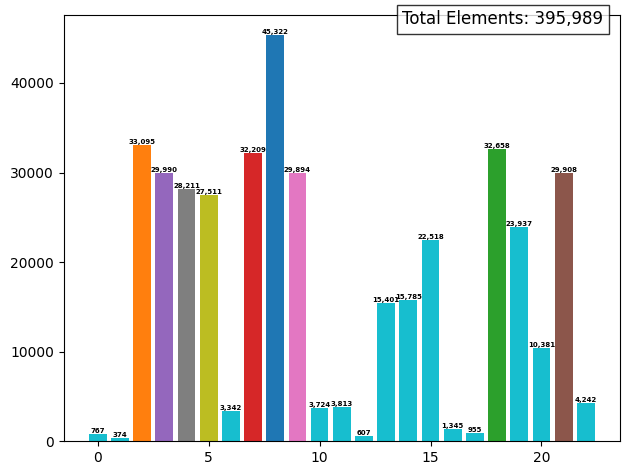

In [40]:
#先绘制被标记setting分布
Pruned_Setting=[loaded_list[i][0]["combined_setting"].values[j+1] for i, j in outliers] # 仅保留异常值对应的序列
result = Counter(Pruned_Setting).most_common(30)
elements, counts = zip(*result)

# 绘制条形图
colors = plt.cm.tab10(np.arange(len(elements)))
bars = plt.bar(elements, counts, color=colors)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',  # 格式化数字添加千位分隔符
             ha='center', va='bottom',
             fontsize=5, fontweight='bold')
    
    # 添加总数信息
total = len(Pruned_Setting)
plt.figtext(0.95, 0.95, f'Total Elements: {total:,}', 
            ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

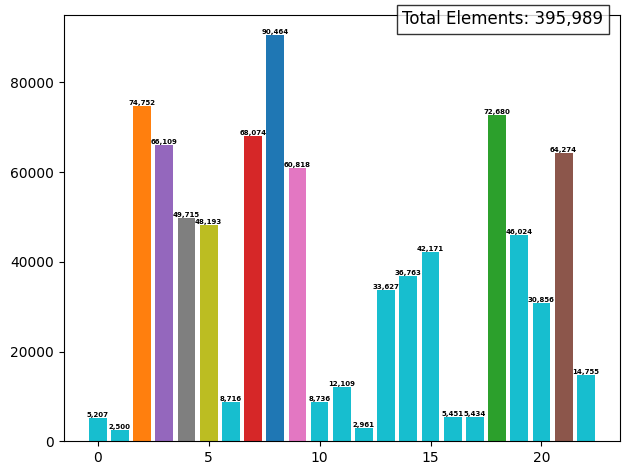

In [41]:
#绘制全体setting分布
All_Setting=[loaded_list[i][0]["combined_setting"].values[j] for i in range(len(loaded_list)) for j in range(len(loaded_list[i][0]["combined_setting"].values))]
result = Counter(All_Setting).most_common(30)
all_elements, counts = zip(*result)

# 绘制条形图
colors = plt.cm.tab10(np.arange(len(elements)))
bars = plt.bar(elements, counts, color=colors)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',  # 格式化数字添加千位分隔符
             ha='center', va='bottom',
             fontsize=5, fontweight='bold')
    
# 添加总数信息
total = len(Pruned_Setting)
plt.figtext(0.95, 0.95, f'Total Elements: {total:,}', 
            ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

### 依据整体模型的标记重新分类

In [42]:
pruned_setting_loss_list=[None]*len(loaded_list)
pruned_time_loss_list=[None]*len(loaded_list)
changed_seq=[]
for i in range(len(loaded_list)):#第i个序列
    seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
    seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
    time_criterion = nn.MSELoss(reduction= "sum")
    setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
    if final_assignment_list[i] >= len(models):
        setting_loss_list[i] = [0]
        time_loss_list[i] = [0]
        continue

    #deltaT_inputs是时间差的输入，setting_inputs是设置的输入
    #使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
    deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
    setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)

    deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
    setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)

    input_len = seq_time.shape[0] - 2#输出输出的长度
    length = torch.tensor([input_len])
    
    #复制原始输入和目标张量，以便在删除异常点后进行修剪,将张量转换为列表（保留二维结构）,存入“pruned_...类型_输入/输出_list”中
    pruned_deltaT_inputs_list, pruned_setting_inputs_list, pruned_deltaT_targets_list, pruned_setting_targets_list= deltaT_inputs.clone().tolist(), setting_inputs.clone().tolist(), deltaT_targets.clone().tolist(), setting_targets.clone().tolist()
    indices_to_remove = [y for _, y in outliers if _ ==i]# 从outlier中提取所有序列标号为i的异常点（即第一个元素为i的数组),忽略x，只取y
    indices_to_remove = sorted(list(set(indices_to_remove)),reverse=True)  # 去重,降序排序(先删后面的，避免改变索引位置),indices_to_remove是储存第i个序列中需要删除的索引列表,注意sorted和.sort的区别
    #***测试用待删print(i,indices_to_remove)

    # 如果没有可删除的，则跳过
    if not indices_to_remove:
        continue
    # 如果所有步骤都是异常点，则跳过
    # ***是否要记录所有步骤都异常的序列的总数**？
    if len(pruned_deltaT_inputs_list[0]) == len(indices_to_remove):
        print("序列",i,"的所有步骤均为异常点，跳过")
        continue
    for index in indices_to_remove:
        # 检查索引index是否在有效范围内
        if 0 <= index < len(pruned_deltaT_inputs_list[0]):# 删除被标记的步骤 <bug:只删去了t_input的异常点,忘记了其他的>
            del pruned_deltaT_inputs_list[0][index]
            del pruned_setting_inputs_list[0][index]
            del pruned_deltaT_targets_list[0][index]
            del pruned_setting_targets_list[0][index]
        else:
            # 可选：处理索引越界情况（例如打印警告或忽略）
            print(f"警告: 索引 {index} 超出范围，忽略删除")
            # 或者直接忽略

    pruned_deltaT_inputs, pruned_setting_inputs, pruned_deltaT_targets, pruned_setting_targets = torch.tensor(pruned_deltaT_inputs_list).to(device),torch.tensor(pruned_setting_inputs_list).to(device), torch.tensor(pruned_deltaT_targets_list).to(device), torch.tensor(pruned_setting_targets_list).to(device)
    # 现在，pruned_()_() 就是删除异常点后的数据链,<bug:忘记使用to(device)>
    pruned_length = torch.tensor([pruned_deltaT_inputs.shape[1]])#pruned_length为删除后的长度，从数据中取，并转化为张量

    #***检验用待删print(pruned_deltaT_inputs_list.shape,pruned_length, pruned_setting_inputs.shape[1])

    #使用所有模型分别计算损失
    model_loss = [0] * len(models) # 初始化每个模型的损失列表
    for j in range(len(models)):
        model = models[j]

        #模型预测
        pruned_predict_deltaT, pruned_predict_setting,_ = model(pruned_deltaT_inputs, pruned_setting_inputs, pruned_length)

        #计算损失,seq代表按每一步计损失并编入列表
        pruned_seq_time_loss_tensor=[time_criterion(pruned_predict_deltaT.squeeze(0)[i], pruned_deltaT_targets.squeeze(0)[i]) for i in range(pruned_predict_deltaT.squeeze(0).shape[0])]
        pruned_seq_setting_loss_tensor=[setting_criterion(pruned_predict_setting.squeeze(0)[i].unsqueeze(0), pruned_setting_targets.squeeze(0)[i].unsqueeze(0)) for i in range(pruned_predict_setting.squeeze(0).shape[0])]
        pruned_seq_setting_loss_list=[_.item() for _ in pruned_seq_time_loss_tensor]
        pruned_seq_time_loss_list=[_.item() for _ in pruned_seq_setting_loss_tensor]

        model_loss[j] = sum(pruned_seq_setting_loss_list)+ sum(pruned_seq_time_loss_list) # 计算剪后序列i在模型j上的总损失
        #***测试用待删print(model_loss[j])

    min_modelloss = min(model_loss)
    min_modelindex = model_loss.index(min_modelloss)#找出剪后的最佳模型
    if min_modelindex != final_assignment_list[i] and final_assignment_list[i] < len(models):#若与原分配不同，则打印并记录
        print("序列",i,"的最佳模型由",final_assignment_list[i],"变为",min_modelindex)
        changed_seq.append(i)
    #else:
    #    ***测试用待删print("模型损失:",model_loss,"序号不变",final_assignment_list[i])#<bug:在print()立马加入print(model_loss)会输出None>

print("总序列数",len(loaded_list))
print("标记数（被重新分类的）",len(set([i[0] for i in outliers])))
print("被改变序列数",len(changed_seq))
print()

序列 12 的最佳模型由 1 变为 0
序列 27 的最佳模型由 0 变为 1
序列 44 的最佳模型由 1 变为 2
序列 50 的最佳模型由 0 变为 1
序列 58 的最佳模型由 2 变为 1
序列 61 的最佳模型由 2 变为 1
序列 67 的最佳模型由 1 变为 0
序列 68 的最佳模型由 2 变为 1
序列 74 的所有步骤均为异常点，跳过
序列 79 的最佳模型由 1 变为 0
序列 85 的最佳模型由 2 变为 0
序列 88 的所有步骤均为异常点，跳过
序列 92 的最佳模型由 1 变为 0
序列 94 的所有步骤均为异常点，跳过
序列 106 的最佳模型由 2 变为 1
序列 113 的最佳模型由 1 变为 2
序列 118 的最佳模型由 2 变为 0
序列 120 的最佳模型由 2 变为 1
序列 121 的最佳模型由 2 变为 1
序列 126 的最佳模型由 2 变为 1
序列 131 的最佳模型由 2 变为 1
序列 148 的最佳模型由 2 变为 1
序列 151 的最佳模型由 2 变为 0
序列 184 的最佳模型由 1 变为 0
序列 186 的最佳模型由 2 变为 0
序列 191 的最佳模型由 2 变为 1
序列 193 的最佳模型由 0 变为 1
序列 195 的最佳模型由 2 变为 0
序列 210 的所有步骤均为异常点，跳过
序列 211 的最佳模型由 1 变为 2
序列 218 的所有步骤均为异常点，跳过
序列 220 的最佳模型由 2 变为 1
序列 222 的所有步骤均为异常点，跳过
序列 226 的最佳模型由 0 变为 2
序列 229 的最佳模型由 2 变为 1
序列 243 的最佳模型由 2 变为 0
序列 244 的最佳模型由 2 变为 0
序列 246 的最佳模型由 2 变为 1
序列 249 的最佳模型由 2 变为 1
序列 254 的最佳模型由 2 变为 1
序列 255 的最佳模型由 1 变为 0
序列 266 的所有步骤均为异常点，跳过
序列 276 的最佳模型由 1 变为 0
序列 280 的最佳模型由 1 变为 0
序列 281 的最佳模型由 2 变为 0
序列 294 的最佳模型由 2 变为 1
序列 296 的最佳模型由 2 变为 1
序列 298 的最佳模型由 2 变为 1
序列 319

In [43]:
print("总序列数",len(loaded_list))
print("标记数（被重新分类的）",len(set([i[0] for i in outliers])))
print("被改变序列数",len(changed_seq))
print()

总序列数 26773
标记数（被重新分类的） 25847
被改变序列数 3774



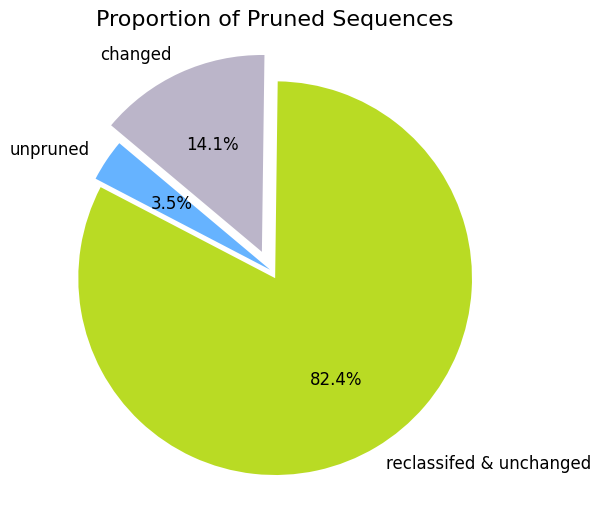

a


In [44]:
total_sequences = len(loaded_list)
reclassified_sequences = len(set([i[0] for i in outliers]))
changed_sequences = len(changed_seq)
unchanged_sequences = total_sequences - reclassified_sequences
reclassified_only = reclassified_sequences - changed_sequences

labels = ['unpruned', 'reclassifed & unchanged', 'changed']
sizes = [unchanged_sequences, reclassified_only, changed_sequences]
colors = ['#66b3ff', "#B9DB24", "#bbb5c9"]
explode = (0, 0.05, 0.1)  # 突出显示

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
plt.title('Proportion of Pruned Sequences', fontsize=16)
plt.axis('equal')
plt.show()
print("a")